#Machine Learning for Classification

In this project, I practice some skills involved in machine learning for classification using Scikit-Learn. I use the New York City Airbnb Open Dataset from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv).


**NOTE**: 

*The target variable in this dataset is price which is a continous numeric variable. Using this data for classifcation (with logistic regression) purpose requires binarizing the price data. I note that this can mask the variation in the data. However, I am proceeding with this approach just for purposes of practicing my skill learnt in this python lesson - machine learning for classification using Scikit-learn.*

###Installing libraries and load data

In [104]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mutual_info_score, accuracy_score, mean_squared_error
from sklearn.linear_model import LogisticRegression, Ridge

Setting up google colab to upload, unzip and read the data from Kaggle.

In [105]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [106]:
#Update Kaggle path to pwd
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [107]:
#Use Kaggle CLI for downloading the data: 
!kaggle datasets download -d dgomonov/new-york-city-airbnb-open-data

new-york-city-airbnb-open-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [108]:
!unzip new-york-city-airbnb-open-data.zip

Archive:  new-york-city-airbnb-open-data.zip
replace AB_NYC_2019.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [162]:
df = pd.read_csv('AB_NYC_2019.csv')

###Checking and cleaning data

In [110]:
len(df)

48895

In [111]:
df.shape

(48895, 16)

####Check for missing values and fill it with 0s

In [112]:
df.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Before further processing, let's select features we will be using in this project

####Selected Features


* ```neighbourhood_group```
* ```room_type```
*```latitude```
*```longitude```
*```price```
*```minimum_nights```
*```number_of_reviews```
*```reviews_per_month```
*```calculated_host_listings_count```
*```availability_365```

In [113]:
sel_cols = ['neighbourhood_group',
'room_type',
'latitude',
'longitude',
'price',
'minimum_nights',
'number_of_reviews',
'reviews_per_month',
'calculated_host_listings_count',
'availability_365']

In [114]:
df = df[sel_cols]

In [115]:
df.head()

,neighbourhood_group,room_type,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Private room,40.64749,-73.97237,149,1,9,0.21,6,365
1,Manhattan,Entire home/apt,40.75362,-73.98377,225,1,45,0.38,2,355
2,Manhattan,Private room,40.80902,-73.94190,150,3,0,NaN,1,365
3,Brooklyn,Entire home/apt,40.68514,-73.95976,89,1,270,4.64,1,194
4,Manhattan,Entire home/apt,40.79851,-73.94399,80,10,9,0.10,1,0


In [116]:
df.head().T

,0,1,2,3,4
neighbourhood_group,Brooklyn,Manhattan,Manhattan,Brooklyn,Manhattan
room_type,Private room,Entire home/apt,Private room,Entire home/apt,Entire home/apt
latitude,40.6475,40.7536,40.809,40.6851,40.7985
longitude,-73.9724,-73.9838,-73.9419,-73.9598,-73.944
price,149,225,150,89,80
minimum_nights,1,1,3,1,10
number_of_reviews,9,45,0,270,9
reviews_per_month,0.21,0.38,NaN,4.64,0.1
calculated_host_listings_count,6,2,1,1,1
availability_365,365,355,365,194,0


In [117]:
df.dtypes

neighbourhood_group                object
room_type                          object
latitude                          float64
longitude                         float64
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

We see that the column names are uniform and their values have the right data types.

Let's covert the string (object) column vaules to lowercase and repalce spaces with underscore.

In [118]:
string_columns = list(df.dtypes[df.dtypes == 'object'].index)  #make a list of rows of string columns where the values are string

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [119]:
df.head().T

,0,1,2,3,4
neighbourhood_group,brooklyn,manhattan,manhattan,brooklyn,manhattan
room_type,private_room,entire_home/apt,private_room,entire_home/apt,entire_home/apt
latitude,40.6475,40.7536,40.809,40.6851,40.7985
longitude,-73.9724,-73.9838,-73.9419,-73.9598,-73.944
price,149,225,150,89,80
minimum_nights,1,1,3,1,10
number_of_reviews,9,45,0,270,9
reviews_per_month,0.21,0.38,NaN,4.64,0.1
calculated_host_listings_count,6,2,1,1,1
availability_365,365,355,365,194,0


Fill missing values with 0

In [120]:
df = df.fillna(0)

In [121]:
df.isna().sum()

neighbourhood_group               0
room_type                         0
latitude                          0
longitude                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [122]:
df.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.090910,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.597283,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


### Q1. What is the mode of ```neighbourhood_group```?

In [123]:
df.neighbourhood_group.mode()

0    manhattan
dtype: object

To see the total frequency of all the values of the ```neighbourhood_group``` variable that makes Manhattan the mode, we can use the value_counts method

In [124]:
df['neighbourhood_group'].value_counts()

manhattan        21661
brooklyn         20104
queens            5666
bronx             1091
staten_island      373
Name: neighbourhood_group, dtype: int64

###Setting up validation framework

**Split the data**

* Split your data in train/val/test sets, with 60%/20%/20% distribution.
*Use Scikit-Learn for that (the train_test_split function) and set the seed to 42.


In [125]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=42) #This splits gives us 80:20 (Train:Test)

We need validation set. So lets apply the train_test_split function to the first 80% Train, df_train_full

In [126]:
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=42)  #Now set the "test_size" which is actually 
                                                                                     # validation size to one-third of the first train 

###Create the y vectors
Take the column with the target variable price and save it outside the dataframe.



In [127]:
#Resetting the indexes
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

df_train_full = df_train_full.reset_index(drop=True)

#Saving the price variable outside the dataframes
y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values

#Deleting price from the dataframes
del df_train['price']
del df_val['price']
del df_test['price']

In [128]:
len(df_train), len(df_val), len(df_test)

(29337, 9779, 9779)

In [129]:
df_train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39116 entries, 0 to 39115
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             39116 non-null  object 
 1   room_type                       39116 non-null  object 
 2   latitude                        39116 non-null  float64
 3   longitude                       39116 non-null  float64
 4   price                           39116 non-null  int64  
 5   minimum_nights                  39116 non-null  int64  
 6   number_of_reviews               39116 non-null  int64  
 7   reviews_per_month               39116 non-null  float64
 8   calculated_host_listings_count  39116 non-null  int64  
 9   availability_365                39116 non-null  int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 3.0+ MB


Checking the mean values of the price variable of the datasets

In [130]:
train_full_mean, train_mean, val_mean, test_mean  = (round(df_train_full.price.mean(),2), round(y_train.mean(),2), round(y_val.mean(),2),round(y_test.mean(),2))

(train_full_mean, train_mean, val_mean, test_mean) 

(153.75, 154.12, 152.65, 148.6)

###Separating categorical and numerical variables for processing

In [131]:
df_train_full.dtypes

neighbourhood_group                object
room_type                          object
latitude                          float64
longitude                         float64
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [132]:
numerical = df_train_full.columns[df_train_full.dtypes != 'object']
categorical = df_train_full.columns[df_train_full.dtypes == 'object']

In [133]:
numerical, categorical

(Index(['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews',
        'reviews_per_month', 'calculated_host_listings_count',
        'availability_365'],
       dtype='object'),
 Index(['neighbourhood_group', 'room_type'], dtype='object'))

We can also use the select_types method as follows

In [134]:
numerical1 = df_train_full.select_dtypes(exclude=['object']).columns.tolist()
categorical1 = df_train_full.select_dtypes(include=['object']).columns.tolist()

###Create correlation matrix for the numerical features.

* What are the two features that have the biggest correlation in this dataset?

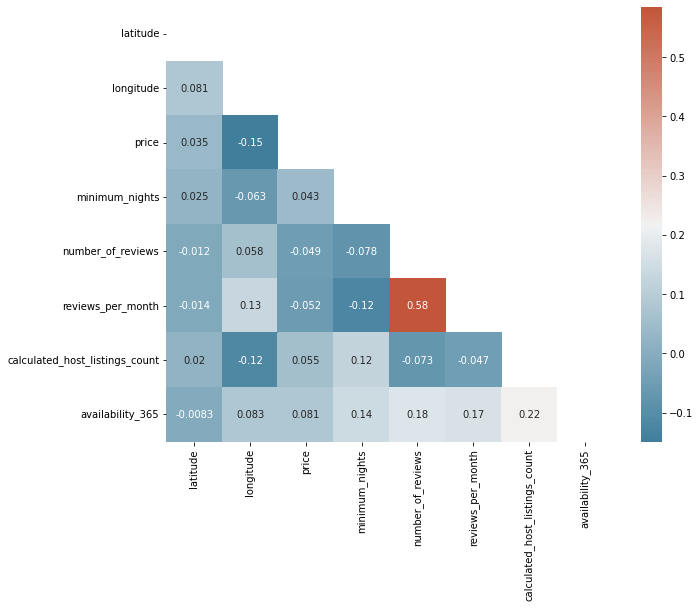

In [135]:
cor_matrix = df_train_full.corr()

plt.subplots(figsize=(10, 8))
# Let's mask the upper triangle
mask = np.triu(np.ones_like(cor_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(cor_matrix, annot=True, mask = mask, cmap=cmap)

Let's consider the correlation for df_train

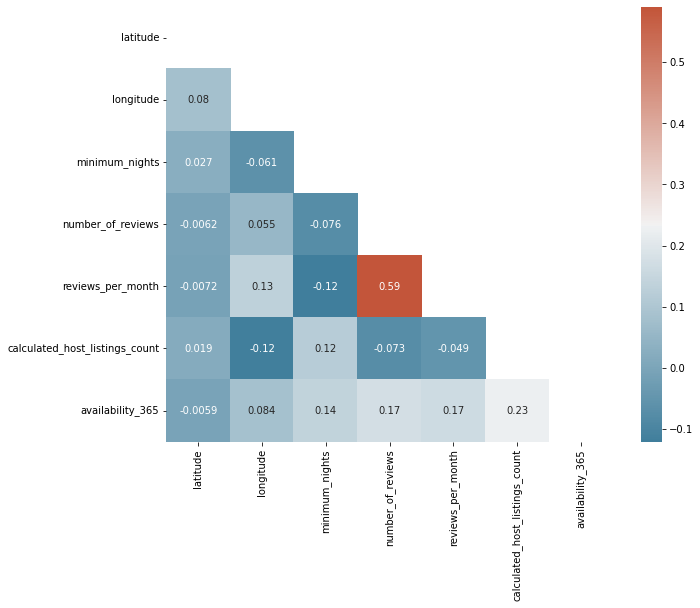

In [136]:
cor_matrix = df_train.corr()

plt.subplots(figsize=(10, 8))
# Let's mask the upper triangle
mask = np.triu(np.ones_like(cor_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(cor_matrix, annot=True, mask = mask, cmap=cmap)

We see that the highest correlation is between ```reviews_per_month``` and ```number_of_reviews``` with correction value of 0.59

###Make price binary
Since we want to use logistic regression, we need to turn the price variable from numeric into binary.
* Let's create a variable ```above_average``` which is 1 if the price is above (or equal to) 152.

In [137]:
y_train_above_average = np.where(y_train >= 152, 1, 0)
y_val_above_average = np.where(y_val >= 152, 1, 0)
y_test_above_average = np.where(y_test >= 152, 1, 0) 

In [138]:
y_train_above_average, y_val_above_average, y_test_above_average

(array([0, 0, 0, ..., 1, 0, 0]),
 array([0, 0, 1, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 1, 0]))

###Feature importance

* Mutual Infomation for categorical values

In [139]:
def calculate_mi(series):                                        
    return mutual_info_score(series, y_train_above_average)        
                                                                  

df_mi = df_train[categorical].apply(calculate_mi).round(2)           #Apply the function calculate_mi to each categorical column of the dataset
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')

display(df_mi)

,MI
room_type,0.14
neighbourhood_group,0.05


We see that ```room_type``` has the higher MI score and thus offers more dependency information than ```neighbourhood_group```.

#### One-hot encoding of the categorical variables

In [140]:

#Redefine numerical to exclude price


numerical = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365']
categorical = ['room_type', 'neighbourhood_group']     

#convert to dictionary
train_dict = df_train[categorical + numerical].to_dict(orient='records')   #'records' are the row values from 
                                                                            #the dataframe for a given column

In [141]:
dv = DictVectorizer(sparse=False)  #the sparse = False parameter ensures we have the output as simple numPy array
dv.fit(train_dict)

DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
               sparse=False)

In [142]:
X_train = dv.transform(train_dict) #Or we can use X_train = dv.fit_transform(train_dict) without first doing dv.fit(train_dict)


#val_dict = df_val.to_dict(orient='records')
#X_val = dv.transform(val_dict)

## Training logistic regression

In [143]:
model = LogisticRegression(solver='lbfgs', C=1.0, max_iter=1000, random_state=42)  #This trains the model 
model.fit(X_train, y_train_above_average)                                      #Apply the model to the train set

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Let's look at the intercept and the coefficients

In [144]:
model.intercept_[0].round(3)

-0.057

In [145]:
model.coef_[0].round(3)

array([ 3.000e-03,  4.000e-03, -5.705e+00, -3.105e+00, -1.100e-02,
       -1.000e-01,  1.180e-01,  1.568e+00, -2.900e-02, -1.611e+00,
       -3.000e-03, -4.500e-02,  1.892e+00, -8.890e-01, -1.058e+00])

In [146]:
dict(zip(dv.get_feature_names(), model.coef_[0].round(3)))

{'availability_365': 0.003,
 'calculated_host_listings_count': 0.004,
 'latitude': -5.705,
 'longitude': -3.105,
 'minimum_nights': -0.011,
 'neighbourhood_group=bronx': -0.1,
 'neighbourhood_group=brooklyn': 0.118,
 'neighbourhood_group=manhattan': 1.568,
 'neighbourhood_group=queens': -0.029,
 'neighbourhood_group=staten_island': -1.611,
 'number_of_reviews': -0.003,
 'reviews_per_month': -0.045,
 'room_type=entire_home/apt': 1.892,
 'room_type=private_room': -0.889,
 'room_type=shared_room': -1.058}

To learn the probabilities we do soft prediction using predict_proba

In [147]:
model.predict_proba(X_train)

array([[0.68079027, 0.31920973],
       [0.86061073, 0.13938927],
       [0.89216861, 0.10783139],
       ...,
       [0.90360347, 0.09639653],
       [0.98231922, 0.01768078],
       [0.39772049, 0.60227951]])

The output above is a two-dimensional array with two columns. The first column is the prob of not churning and the second is the prob of churning.

To make a dcision on which customers will churn, we only need the second column.

In [148]:
y_pred = model.predict_proba(X_train)[:,1]
y_pred

array([0.31920973, 0.13938927, 0.10783139, ..., 0.09639653, 0.01768078,
       0.60227951])

####Validation

We need to make sure of validation data is also one-hot encoded.

In [149]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

Then we can now validate using the validation X

In [150]:
model.predict_proba(X_val)

array([[0.97142811, 0.02857189],
       [0.40648438, 0.59351562],
       [0.57491103, 0.42508897],
       ...,
       [0.88630079, 0.11369921],
       [0.96566415, 0.03433585],
       [0.46869753, 0.53130247]])

In [151]:
y_pred = model.predict_proba(X_val)[:, 1]

y_pred

array([0.02857189, 0.59351562, 0.42508897, ..., 0.11369921, 0.03433585,
       0.53130247])

####Price decision

In [152]:
price_decision = (y_pred >= 0.5)

###Accuracy of the model

* Calculate the accuracy on the validation dataset and rount it to 2 decimal digits.

This requires checking if our predictions match the actuals - this is a simple check of model quality.

We can calculate the accuracy as follows:

In [153]:
(y_val_above_average == price_decision).mean().round(2)

0.79

Thus our model is 79% accurate using the threshold established by the price_decision.

We can create a dataframe to showcase these matches/mismatches.

In [154]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = price_decision.astype(int)
df_pred['actual'] = y_val_above_average
df_pred['correct'] = df_pred.prediction == df_pred.actual

df_pred

,probability,prediction,actual,correct
0,0.028572,0,0,True
1,0.593516,1,0,False
2,0.425089,0,1,False
3,0.075216,0,0,True
4,0.811258,1,1,True
...,...,...,...,...
9774,0.637999,1,1,True
9775,0.012739,0,0,True
9776,0.113699,0,0,True
9777,0.034336,0,0,True


### A Step-by-step model accuracy comparison 
We have 9 features: 7 numerical features and 2 categorical.
We want to find the least useful one using the feature elimination technique.

To achieve this, we will use a rather explicit approach:
*Train a model with all these features (using the same parameters as above).
* Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
* For each feature, calculate the difference between the original accuracy and the accuracy without the feature.
* Which of following features has the smallest difference?
```
neighbourhood_group
room_type
number_of_reviews
reviews_per_month


###Model with all Features

In [155]:

model1 = LogisticRegression(solver='lbfgs', C=1.0, max_iter=1000, random_state=42) 
model1.fit(X_train, y_train_above_average)
y_pred1 = model1.predict_proba(X_val)[:, 1]
price_decision1 = (y_pred1 >= 0.5)
df_pred1 = pd.DataFrame()
df_pred1['probability'] = y_pred1
df_pred1['prediction'] = price_decision1.astype(int)
df_pred1['actual'] = y_val_above_average
df_pred1['correct'] = df_pred1.prediction == df_pred1.actual
model1_accuracy = round(df_pred1.correct.mean(),2)
print('Accuracy for the model with all features is {0}.'.format(model1_accuracy))


Accuracy for the model with all features is 0.79.


Let's define the features of all our models and apply a for loop to run the regressions

In [156]:
# no feature removed
model_1_features = ['room_type','availability_365','calculated_host_listings_count','latitude','longitude','minimum_nights','neighbourhood_group','number_of_reviews','reviews_per_month']
# room_type removed
model_2_features = ['availability_365','calculated_host_listings_count','latitude','longitude','minimum_nights','neighbourhood_group','number_of_reviews','reviews_per_month']
# reviews_per_month removed
model_3_features = ['availability_365','calculated_host_listings_count','latitude','longitude','minimum_nights','neighbourhood_group','number_of_reviews','room_type']
# number_of_reviews removed
model_4_features = ['availability_365','calculated_host_listings_count','latitude','longitude','minimum_nights','neighbourhood_group','reviews_per_month','room_type']
# neighbourhood_group removed
model_5_features = ['availability_365','calculated_host_listings_count','latitude','longitude','minimum_nights','number_of_reviews','reviews_per_month','room_type']
# minimum_nights removed
model_6_features = ['availability_365','calculated_host_listings_count','latitude','longitude','neighbourhood_group','number_of_reviews','reviews_per_month','room_type']
# longitude removed
model_7_features = ['availability_365','calculated_host_listings_count','latitude','minimum_nights','neighbourhood_group','number_of_reviews','reviews_per_month','room_type']
# latitude removed
model_8_features = ['availability_365','calculated_host_listings_count','longitude','minimum_nights','neighbourhood_group','number_of_reviews','reviews_per_month','room_type']
# calculated_host_listings_count removed
model_9_features = ['availability_365','latitude','longitude','minimum_nights','neighbourhood_group','number_of_reviews','reviews_per_month','room_type']
# availability_365 removed
model_10_features = ['calculated_host_listings_count','latitude','longitude','minimum_nights','neighbourhood_group','number_of_reviews','reviews_per_month','room_type']

In [157]:


feature_dict = {'model1 - all features - none removed': model_1_features, 'model2 - room_type removed':model_2_features, 'model3 - reviews_per_month removed':model_3_features,
                'model4 - number_of_reviews removed': model_4_features,'model5 - neighbourhood_group removed': model_5_features,'model6 - minimum_nights removed': model_6_features,
                'model7 - longitude removed':model_7_features, 'model8 - latitude removed': model_8_features, 'model9 - calculated_host_listings_count removed': model_9_features, 
                'model10 - availability_365 removed': model_10_features}

accuracy_list = []

for key, a_list in feature_dict.items():
  train_dict = df_train[a_list].to_dict(orient='records')
  train_val = df_val[a_list].to_dict(orient='records')
  dv = DictVectorizer(sparse=False)
  dv.fit(train_dict)
  X_train = dv.transform(train_dict)
  X_val = dv.transform(train_val)
  model = LogisticRegression(solver='lbfgs', C=1.0, max_iter=1000, random_state=42)
  model.fit(X_train, y_train_above_average)
  
  y_pred = model.predict_proba(X_val)[:, 1]
  price_decision = (y_pred >= 0.5)
  model_accuracy = (y_val_above_average == price_decision).mean().round(2)
  accuracy_list.append(model_accuracy)
  diff = (accuracy_list[0]-model_accuracy).round(2)
  #print(key, model_accuracy, diff)
  print(model_accuracy, diff, key)

0.79 0.0 model1 - all features - none removed
0.73 0.06 model2 - room_type removed
0.79 0.0 model3 - reviews_per_month removed
0.79 0.0 model4 - number_of_reviews removed
0.75 0.04 model5 - neighbourhood_group removed
0.79 0.0 model6 - minimum_nights removed
0.79 0.0 model7 - longitude removed
0.79 0.0 model8 - latitude removed
0.79 0.0 model9 - calculated_host_listings_count removed
0.78 0.01 model10 - availability_365 removed


So we see ```number_of_reviews``` and ```reviews_per_month``` when removed from the model we have the smallest difference in accuracy. In fact, no difference at all.

##Linear Regression in Scikit-Learn

* We'll need to use the original column 'price'. Apply the logarithmic transformation to this column.
* Fit the Ridge regression model on the training data.
* This model has a parameter alpha. Let's try the following values: [0, 0.01, 0.1, 1, 10]
* Which of these alphas leads to the best RMSE on the validation set? Round your RMSE scores to 3 decimal digits.

Before apply log to the ```price``` we want to fill any nans with mean of price and later add 1 to all the price values.

In [158]:
train_mean

154.12

Let's fill in our split data with train mean

In [159]:
y_train[y_train == 0] = train_mean
y_val[y_val == 0] = train_mean
y_test[y_test == 0] = train_mean

Log-transform

In [160]:
y_train = np.log(y_train)
y_val = np.log(y_val)
y_test = np.log(y_test)

Train the model and validate and compute the RMSEs

In [161]:
alpha_values = [0, 0.01, 0.1, 1, 10]
rmses = []

for alpha in alpha_values:
    model = Ridge(alpha)
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    rmses.append(rmse)
    print('Ridge Regression with alpha = {0}, gives RMSE on validation set as {1}'.format(alpha, round(rmse,3)))

Ridge Regression with alpha = 0, gives RMSE on validation set as 0.508
Ridge Regression with alpha = 0.01, gives RMSE on validation set as 0.508
Ridge Regression with alpha = 0.1, gives RMSE on validation set as 0.508
Ridge Regression with alpha = 1, gives RMSE on validation set as 0.508
Ridge Regression with alpha = 10, gives RMSE on validation set as 0.509


Here alpha = 0 is the least alpha with least RMSE of 0.508